In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from inspect import getfullargspec

In [409]:
def compute_gradient(u,x0,dx=1e-7): #функция, приближенно вычисляющая градиент в точке
    n = len(x0)
    gradient = np.zeros(n)
    for i in range(n):
        delta = np.array([0 if j != i else dx for j in range(n)])
        gradient[i] = (u(*(x0+delta))-u(*x0))/dx
    return gradient

In [410]:
def gradient_descent(f,learning_rate,eps,dx=1e-7): #алгоритм градиентного спуска
    max_iters = 2000
    num_of_iters = 0
    n = len(getfullargspec(f)[0])
    teta0 = np.array([np.random.normal() for _ in range(n)])
    teta1 = teta0 - learning_rate*compute_gradient(f,teta0,dx)
    while(norm(teta0-teta1)>eps and num_of_iters < max_iters):
        num_of_iters +=1
        teta0 = teta1
        teta1 = teta0 - learning_rate*compute_gradient(f,teta0,dx)
    return teta0, num_of_iters

In [411]:
def nesterov_method(f,eps): #метод Нестерова
    n = len(getfullargspec(f)[0])
    y1 = np.array([np.random.normal() for _ in range(n)])
    z = np.array([np.random.normal() for _ in range(n)])
    k = 0
    a1 = 1
    x0 = y1
    a0 = norm(y1-z)/norm(compute_gradient(f,y1)-compute_gradient(f,z))
    i = 0
    while f(*y1)-f(*(y1-2**(-i)*a0*compute_gradient(f,y1)))<2**(-i-1)*a0*(norm(compute_gradient(f,y1))**2):
        i+=1
    a1 = 2**(-i)*a0
    x1 = y1-a1*compute_gradient(f,y1)
    a2 = (1+(4*a1**2+1)**0.5)/2
    y2 = x1+((a1-1)*(x1-x0))/a2
    while (norm(y1-y2)>eps and k < 2000):
        k+=1
        a0,a1,x0,y1 = a1,a2,x1,y2
        i = 0
        while f(*y1)-f(*(y1-2**(-i)*a0*compute_gradient(f,y1)))<2**(-i-1)*a0*(norm(compute_gradient(f,y1))**2):
            i+=1
        a1 = 2**(-i)*a0
        x1 = y1-a1*compute_gradient(f,y1)
        a2 = (1+(4*a1**2+1)**0.5)/2
        y2 = x1+((a1-1)*(x1-x0))/a2
    return y2,k

Определим линейную функцию и попробуем с помощью градиентного спуска "восстановить" ее:

In [412]:
def g(x):
    return 4*x+11

In [413]:
N = 100
a,b = -10,10
h = (b-a)/N
X = np.array([a+i*h for i in range(N)])
Y = np.array([g(x) for x in X])

Определим квадратичную функцию потерь:

In [414]:
def loss_function(X,Y):
    return lambda a,b: np.sum(np.array([0.5*(a*x+b-y)**2 for x,y in zip (X,Y)]))

In [415]:
f = loss_function(X,Y) 

In [416]:
ans_desc = pd.DataFrame(columns = ["lambda","eps","iters","|a_eps-a|","|b_eps-b|","loss"])

for i in range(2,7,2):
    for j in range(2,7,2):
        lmbda,eps = 10**(-i),10**(-j)
        res, k = gradient_descent(f,lmbda,eps)
        row = [lmbda,eps,k,abs(res[0]-4),abs(res[1]-11),f(*res)]
        ans_desc = ans_desc.append(pd.Series(row,index=ans_desc.columns),True)

ans_desc

,lambda,eps,iters,|a_eps-a|,|b_eps-b|,loss
0,0.010000,0.010000,6.0,4.751511e+09,7.840829e+05,3.763559e+22
1,0.010000,0.000100,6.0,3.547124e+09,7.871328e+05,2.097432e+22
2,0.010000,0.000001,6.0,1.285882e+10,1.635176e+09,2.755606e+23
3,0.000100,0.010000,245.0,3.087896e-03,9.986188e-01,4.984704e+01
4,0.000100,0.000100,705.0,3.093575e-05,9.988549e-03,4.987061e-03
5,0.000100,0.000001,1154.0,3.571098e-07,9.932190e-05,4.930999e-07
6,0.000001,0.010000,209.0,3.007841e+00,9.757029e+00,1.954803e+04
7,0.000001,0.000100,2000.0,3.171068e-02,8.873353e+00,3.935682e+03
8,0.000001,0.000001,2000.0,3.581300e-02,1.031192e+01,5.315227e+03


In [417]:
ans_nest = pd.DataFrame(columns = ["eps","iters","|a_eps-a|","|b_eps-b|","loss"])

for j in range(2,9,2):
    eps = 10**(-j)
    res, k = nesterov_method(f,eps)
    row = [eps,k,abs(res[0]-4),abs(res[1]-11),f(*res)]
    ans_nest = ans_nest.append(pd.Series(row,index=ans_nest.columns),True)

ans_nest

,eps,iters,|a_eps-a|,|b_eps-b|,loss
0,1.000000e-02,0.0,3.536832e+00,12.267011,2.794292e+04
1,1.000000e-04,378.0,2.976319e-04,0.096239,4.629577e-01
2,1.000000e-06,1270.0,2.384787e-06,0.000755,2.849868e-05
3,1.000000e-08,1912.0,6.642801e-08,0.000005,1.416031e-09


Теперь "зашумим" нашу функцию: 

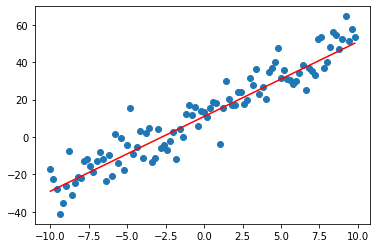

In [418]:
Y1 = np.array([g(x)+np.random.normal(0,8,1) for x in X])

plt.scatter(X,Y1)

plt.plot(X,Y,color="red")

In [419]:
f1 = loss_function(X,Y) 

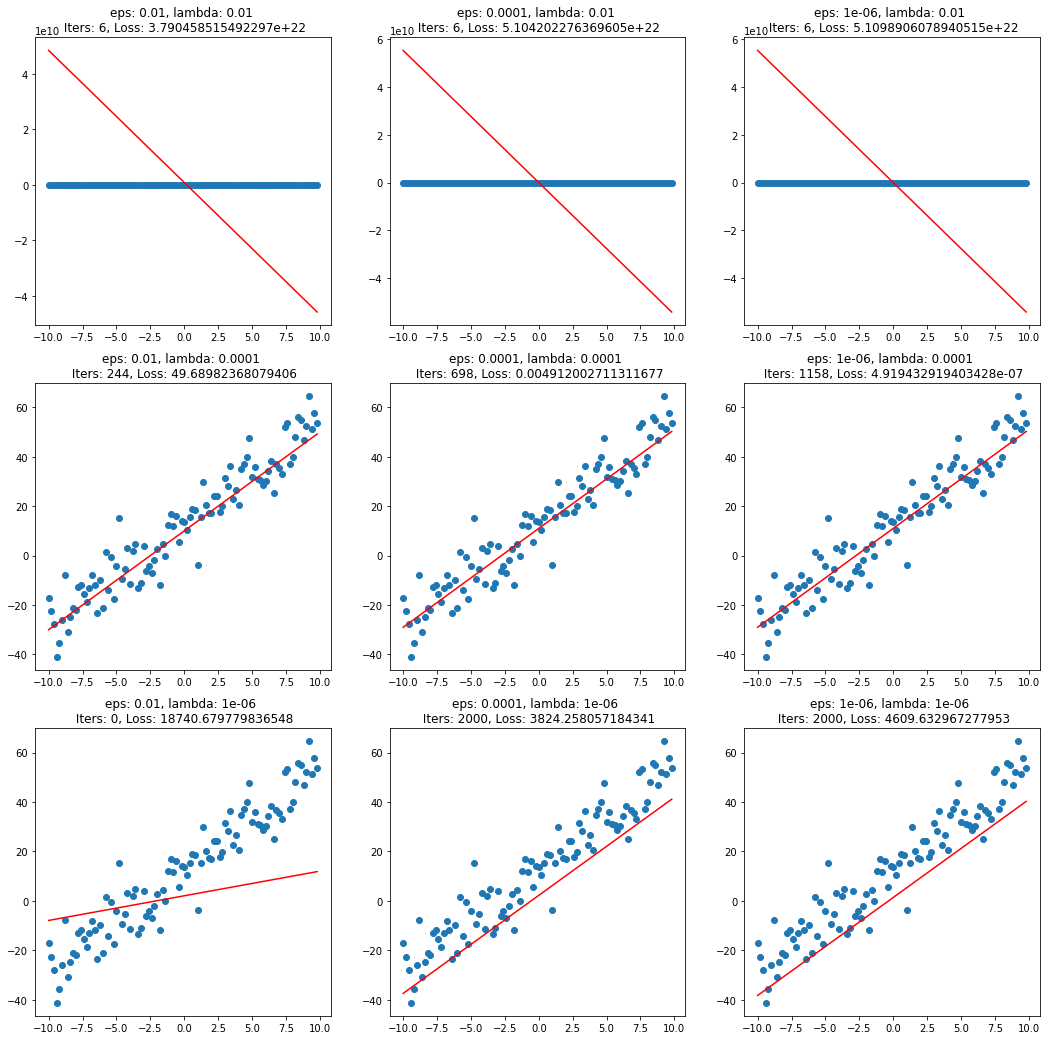

In [420]:
fig,axes = plt.subplots(3,3,figsize=(18,18))

for i in range(3):
    for j in range(3):
        lmbda,eps = 10**(-((i+1)*2)),10**(-((j+1)*2))
        res, k = gradient_descent(f1,lmbda,eps)
        axes[i,j].scatter(X,Y1)
        axes[i,j].plot(X,np.array([res[0]*x+res[1] for x in X]),color="red")
        axes[i,j].set_title("eps: {}, lambda: {} \n Iters: {}, Loss: {}".format(eps,lmbda,k,f1(*res)))
        
fig.savefig("Lab14_graph1")

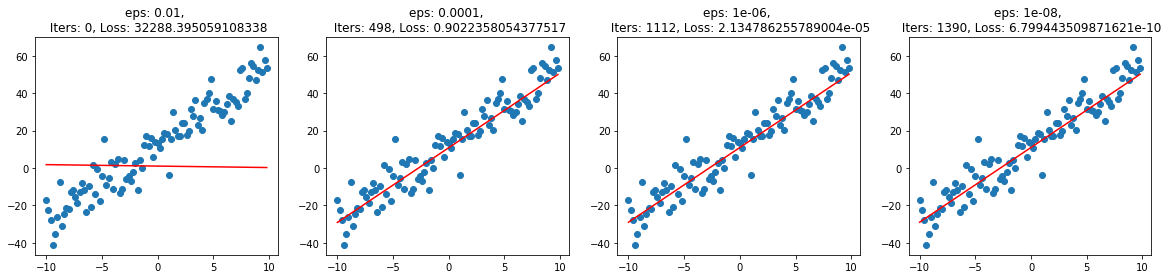

In [421]:
fig1,axes1 = plt.subplots(1,4,figsize=(20,4))

for j in range(4):
        eps = 10**(-((j+1)*2))
        res, k = nesterov_method(f1,eps)
        axes1[j].scatter(X,Y1)
        axes1[j].plot(X,np.array([res[0]*x+res[1] for x in X]),color="red")
        axes1[j].set_title("eps: {}, \n Iters: {}, Loss: {}".format(eps,k,f1(*res)))
        
fig1.savefig("Lab14_graph2")